In [1]:
import numpy
import tensorboard as tensorboard
import seaborn as seaborn
from tensorflow.python.client import device_lib
import tensorflow as tf
config = tf.compat.v1.ConfigProto(gpu_options = 
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
# device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)
import os
import pandas as pd
import shap
import numpy as np
import seaborn as sns
from skimage.segmentation import slic
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import kr_helper_funcs as kr
print('tensorflow' + tf.__version__)
print('tensorboard' + tensorboard.__version__)
print('seaborn' + seaborn.__version__)
tf.config.list_physical_devices('GPU')
print(tf.test.is_built_with_cuda)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')
device_lib.list_local_devices()

tensorflow2.2.0
tensorboard2.2.2
seaborn0.10.1
<function is_built_with_cuda at 0x00000218AA0B3280>
Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2679007030603798193,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13798731480736407817
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6871947673
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9815487538075634759
 physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:3a:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14734928384358175719
 physical_device_desc: "device: XLA_GPU device"]

In [2]:
data_dir="../input/kaggle-flowers"
test_path= os.path.join(data_dir, 'test')

os.listdir(test_path)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [3]:
image_shape =(250, 250, 3)
test_gen = ImageDataGenerator(rescale =1./255)
batch_size=32
test_image_gen= test_gen.flow_from_directory(test_path, target_size=image_shape[:2], 
                                               color_mode='rgb', batch_size=batch_size, 
                                               class_mode='categorical',  shuffle=False)
test_image_gen.class_indices

Found 750 images belonging to 5 classes.


{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000218DBF5ABE0> and <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000218DBF7E4F0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000218DBFBB220> and <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000218DBFC3520>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000218DBFC3760> and <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000218DBFC9610>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x00000218DBFC9F70> and <tensorflow.python.keras.layers.core.Dropout object at 0x00000218DBFD0460>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Den

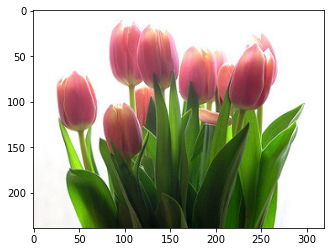

In [4]:
import shap
import numpy as np
X_test, _ = test_image_gen.next()
# background = X_test[np.random.choice(20, 10, replace=False)]
background = X_test[0:5]
# explain predictions of the model on three images
# e = shap.DeepExplainer(tf.keras.models.load_model('flowers'), background)

model =tf.keras.models.load_model('flowers')
tulip_image_path = test_path + '/tulip/' + os.listdir(test_path + '/tulip/')[5]
# plt.imshow(imread(dog_image))
img = image.load_img(tulip_image_path, target_size=(250, 250, 3))
plt.imshow(imread(tulip_image_path))
img_orig = image.img_to_array(img)
standardized_image = test_gen.standardize(img_orig)


In [5]:
# segment the image so we don't have to explain every pixel
segments_slic = slic(img, n_segments=50, compactness=30, sigma=3)

# define a function that depends on a binary mask representing if an image region is hidden
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out
def f(z):
    return model.predict(test_gen.standardize(mask_image(z, segments_slic, img_orig, 250)))

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


In [6]:
# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1,50)))
shap_values = explainer.shap_values(np.ones((1,50)), nsamples=1000) # runs VGG16 1000 times

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


In [7]:
len(shap_values[1][0])

50

In [8]:
# get the top predictions from the model
preds = model.predict(test_gen.standardize(np.expand_dims(img_orig.copy(), axis=0)))
top_preds = np.argsort(-preds)

In [9]:
# make a color map
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)

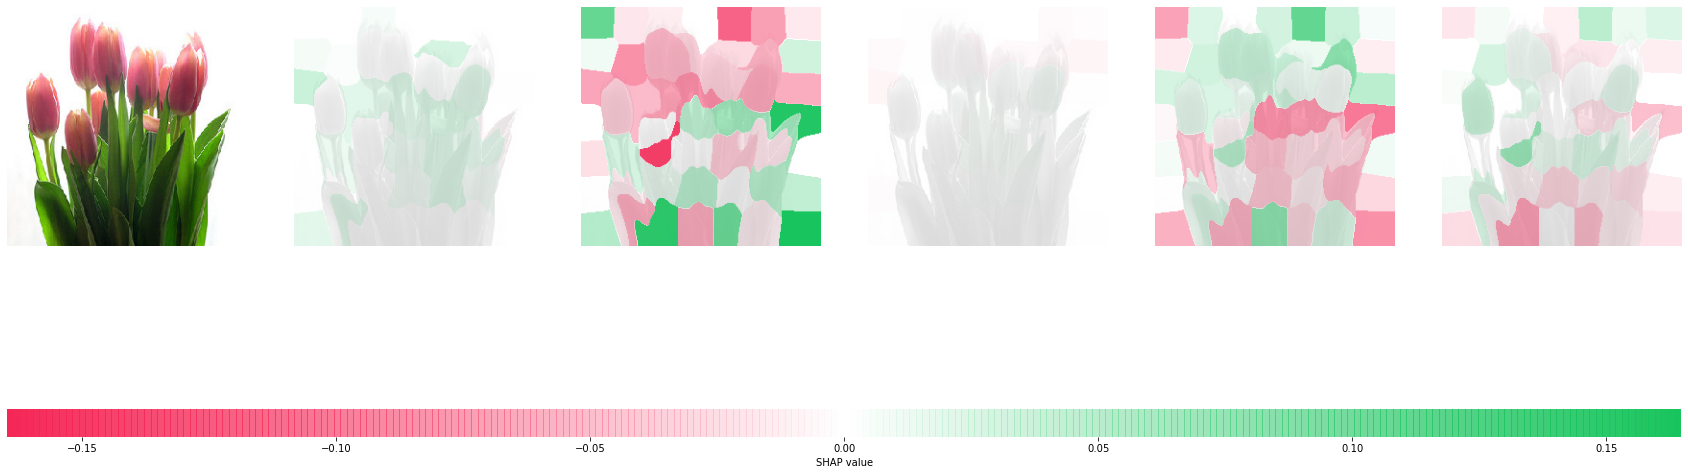

In [10]:
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

# plot our explanations
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(30,20))
inds = top_preds[0]
axes[0].imshow(img)
axes[0].axis('off')
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(5):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
#     axes[i+1].set_title(feature_names[str(inds[i])][1])
    axes[i+1].imshow(img.convert('LA'), alpha=0.15)
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


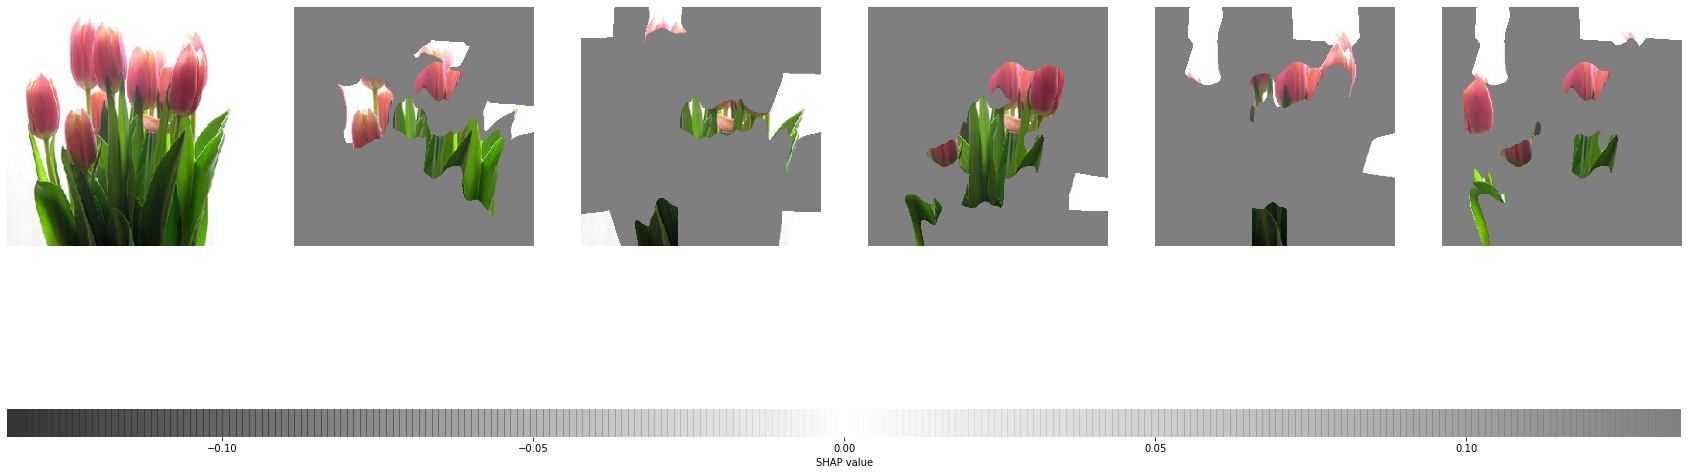

In [21]:
# segment the image so we don't have to explain every pixel
segments_slic = slic(img, n_segments=50, compactness=30, sigma=3)


def extract_top_ten(shap_values):
    new_shap_values=[]
    for values in shap_values:
        shap_list = list(set([item for sublist in values for item in sublist]))
        shap_list.sort(reverse=True)
        shap_list = shap_list[:10]
        new_values = [numpy.asarray([a if a in shap_list else 0 for a in list]) for list in values] # filter out negative values and keep top 10
        new_shap_values.append(new_values)
    shap_values = numpy.asarray(new_shap_values)
    return shap_values

# define a function that depends on a binary mask representing if an image region is hidden
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out
def f(z):
    return model.predict(test_gen.standardize(mask_image(z, segments_slic, img_orig, 250)))

# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1,50)))
shap_values = explainer.shap_values(np.ones((1,50)), nsamples=1000) # runs model 1000 times

shap_values = extract_top_ten(shap_values)

# get the top predictions from the model
preds = model.predict(test_gen.standardize(np.expand_dims(img_orig.copy(), axis=0)))
top_preds = np.argsort(-preds)

# make a color map
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((0.2,0.2,0.2,l))
for l in np.linspace(0,1,100):
    colors.append((0.5,0.5,0.5,l))
cm = LinearSegmentedColormap.from_list("shap", colors)

def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = 0 if values[i]> 0 else 1
    return out

# plot our explanations
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(30,20))
inds = top_preds[0]
axes[0].imshow(img)
axes[0].axis('off')
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(5):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
#     axes[i+1].set_title(feature_names[str(inds[i])][1])
    axes[i+1].imshow(img)
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    plt.savefig('foo.png')
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


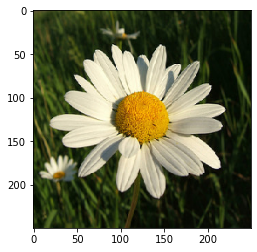

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


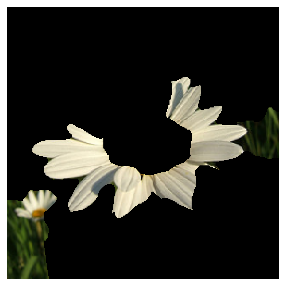

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


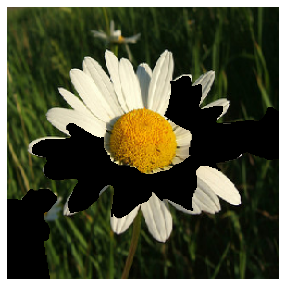

Original Class: 0 original confidence:0.9988133907318115 new class top:0 new confidence top:0.8934534788131714 new class rest:0 new confidence rest:0.9882965683937073


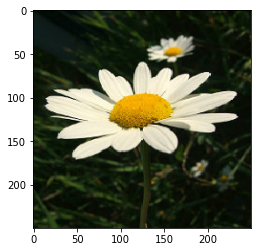

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


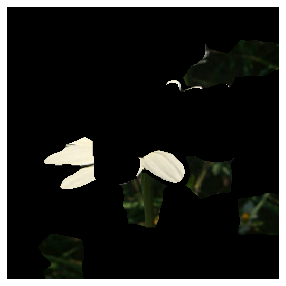

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


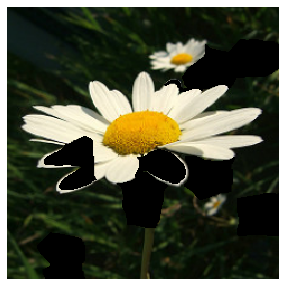

Original Class: 0 original confidence:0.9987307190895081 new class top:0 new confidence top:0.936905026435852 new class rest:0 new confidence rest:0.9855755567550659


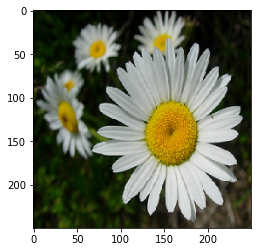

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


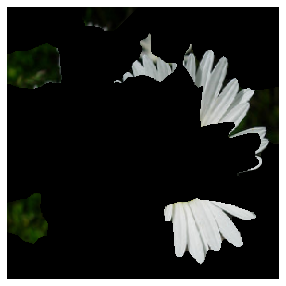

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


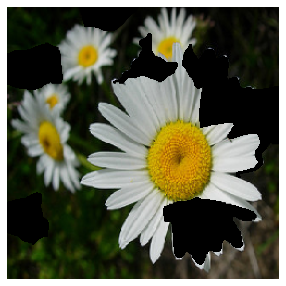

Original Class: 0 original confidence:0.9998452663421631 new class top:0 new confidence top:0.9721426367759705 new class rest:0 new confidence rest:0.998727023601532


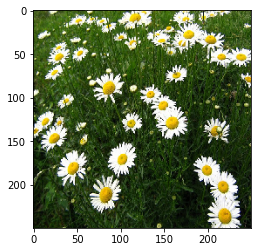

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


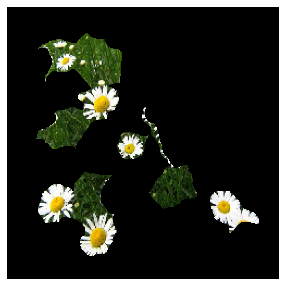

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


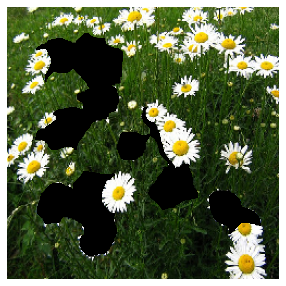

Original Class: 0 original confidence:0.99992835521698 new class top:0 new confidence top:0.9980533123016357 new class rest:0 new confidence rest:0.9925132393836975


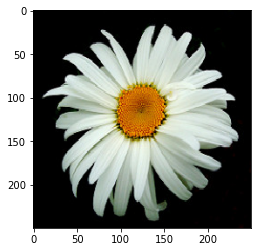

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


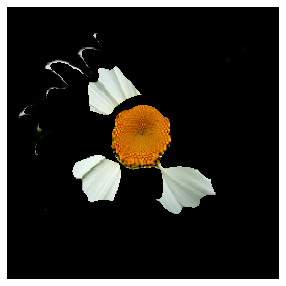

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


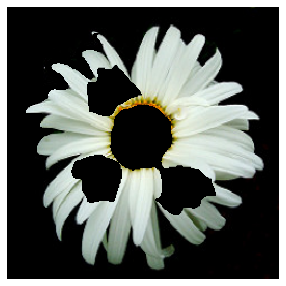

Original Class: 0 original confidence:0.9997989535331726 new class top:2 new confidence top:0.41780272126197815 new class rest:0 new confidence rest:0.9900840520858765


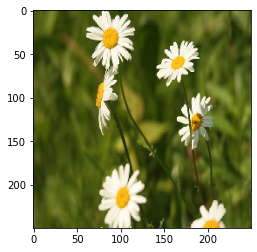

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


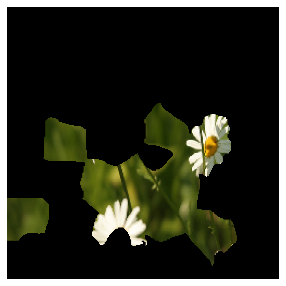

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


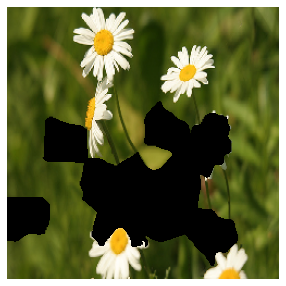

Original Class: 0 original confidence:0.9865379333496094 new class top:0 new confidence top:0.5566481947898865 new class rest:0 new confidence rest:0.6940390467643738


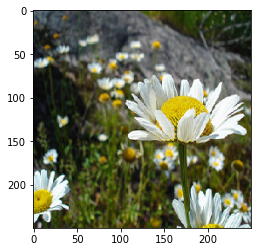

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


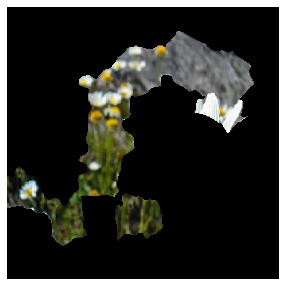

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


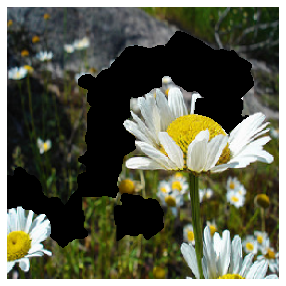

Original Class: 0 original confidence:0.9828159213066101 new class top:0 new confidence top:0.6781732439994812 new class rest:0 new confidence rest:0.8442530632019043


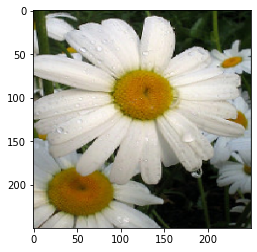

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


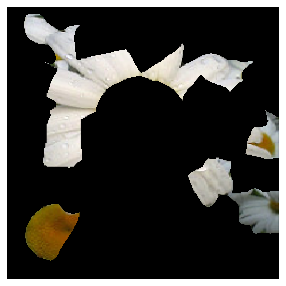

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


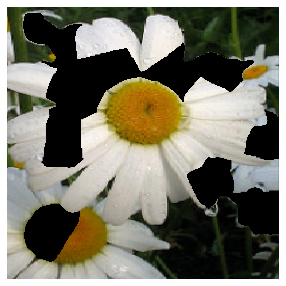

Original Class: 0 original confidence:0.8826208114624023 new class top:0 new confidence top:0.7726948857307434 new class rest:2 new confidence rest:0.09086242318153381


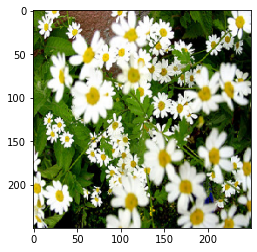

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


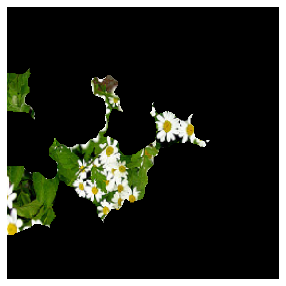

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


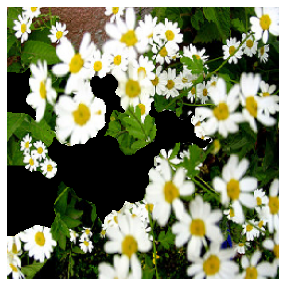

Original Class: 0 original confidence:0.9999741315841675 new class top:0 new confidence top:0.8706848621368408 new class rest:0 new confidence rest:0.9998338222503662


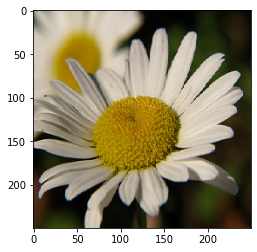

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


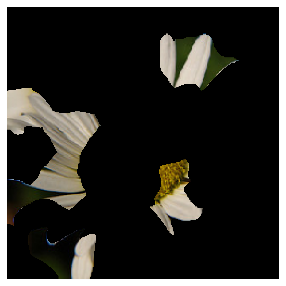

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


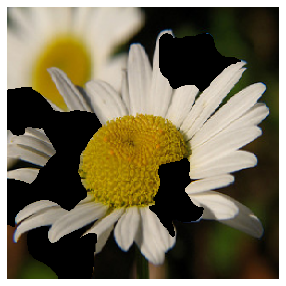

Original Class: 0 original confidence:0.9933351278305054 new class top:0 new confidence top:0.7463722825050354 new class rest:0 new confidence rest:0.9731727242469788


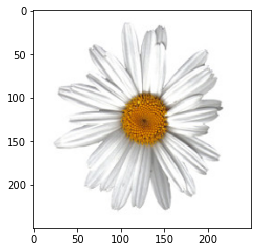

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


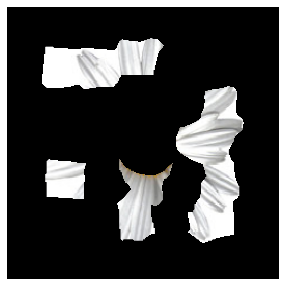

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


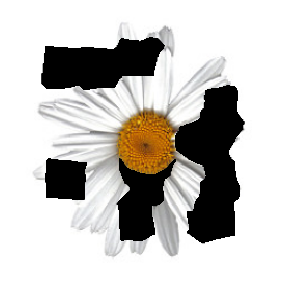

Original Class: 0 original confidence:0.9149937629699707 new class top:0 new confidence top:0.9677542448043823 new class rest:0 new confidence rest:0.9757362008094788


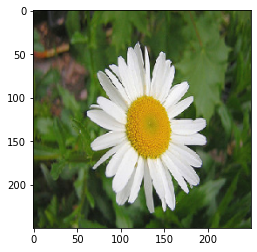

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


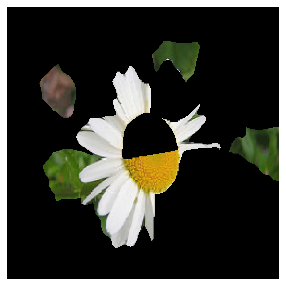

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


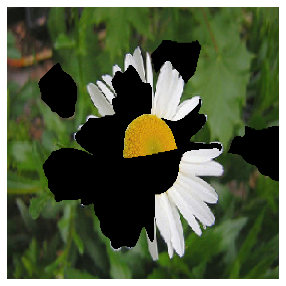

Original Class: 0 original confidence:0.9996649026870728 new class top:0 new confidence top:0.9547138810157776 new class rest:0 new confidence rest:0.5866624116897583


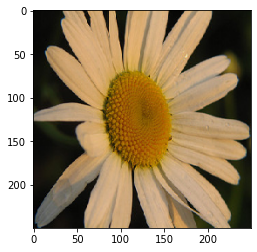

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


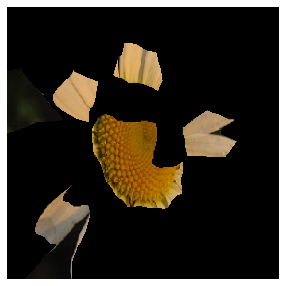

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


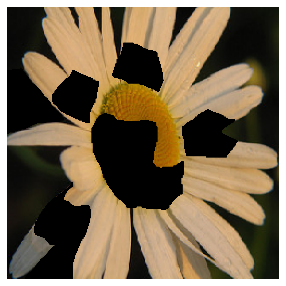

Original Class: 0 original confidence:0.7954168915748596 new class top:2 new confidence top:0.1496352106332779 new class rest:3 new confidence rest:0.2591434121131897


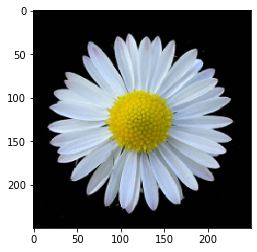

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.




Traceback (most recent call last):
  File "c:\users\dan39\onedrive\desktop\dissertation\python3.8\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-962a13f6f554>", line 121, in <module>
    new_class_top, new_prediction_top, new_class_rest, new_prediction_rest = calculate_predictions(img, original_class)
  File "<ipython-input-22-962a13f6f554>", line 42, in calculate_predictions
    shap_values = explainer.shap_values(np.ones((1,50)), nsamples=1000) # runs model 1000 times
  File "c:\users\dan39\onedrive\desktop\dissertation\python3.8\lib\site-packages\shap\explainers\kernel.py", line 211, in shap_values
    explanations.append(self.explain(data, **kwargs))
  File "c:\users\dan39\onedrive\desktop\dissertation\python3.8\lib\site-packages\shap\explainers\kernel.py", line 401, in explain
    self.run()
  File "c:\users\dan39\onedrive\desktop\dissertation\python3.8\lib\site-packages\s

TypeError: object of type 'NoneType' has no len()

In [22]:
# make a color map
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((0,0,0,l))
for l in np.linspace(0,1,100):
    colors.append((0,0,0,l))
cm = LinearSegmentedColormap.from_list("shap", colors)


def fill_segmentation(values, segmentation, keep_top):
        out = np.zeros(segmentation.shape)
        for i in range(len(values)):
            if keep_top:
                out[segmentation == i] = 0 if values[i]> 0 else 1
            else:
                out[segmentation == i] = 1 if values[i]> 0 else 0
        return out

    # define a function that depends on a binary mask representing if an image region is hidden
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out


def calculate_predictions(img_orig, original_class):
    # segment the image so we don't have to explain every pixel
    segments_slic = slic(img_orig, n_segments=50, compactness=30, sigma=3)
    
    def f(z):
        return model.predict(test_gen.standardize(mask_image(z, segments_slic, img_orig, 250)))
    
    # use Kernel SHAP to explain the network's predictions
    explainer = shap.KernelExplainer(f, np.zeros((1,50)))
    shap_values = explainer.shap_values(np.ones((1,50)), nsamples=1000) # runs model 1000 times

    # get the top predictions from the model
    preds = model.predict(test_gen.standardize(np.expand_dims(img_orig.copy(), axis=0)))
    top_preds = np.argsort(-preds)
    
    shap_values = [np.where(a<0, 0, a) for a in shap_values]
    shap_values = extract_top_ten(shap_values)
   
    # plot our explanations for top shap superpixels
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    inds = top_preds[0]

    max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])

    m = fill_segmentation(shap_values[inds[original_class]][0], segments_slic, True)
    #     axes[i+1].set_title(feature_names[str(inds[i])][1])
    plt.imshow(img_orig)
    plt.imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    plt.axis('off')
    plt.margins(0,0)
    # cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
    # cb.outline.set_visible(False)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig("foo.png", bbox_inches = 'tight',
        pad_inches = 0)
    plt.show()
    img = image.load_img("foo.png", target_size=(250, 250, 3))
    new_img = image.img_to_array(img)
    standardized_image = test_gen.standardize(new_img)
    plt.imshow((standardized_image))
    
    new_class_top = model.predict_classes(standardized_image.reshape(1,250,250,3))[0]
    new_prediction_top = model.predict(standardized_image.reshape(1,250,250,3))[0][original_class]
    
    plt.close()
    segments_slic = slic(img_orig, n_segments=50, compactness=30, sigma=3)
    # plot our explanations without top ssuper pixels
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    inds = top_preds[0]

    max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])

    m = fill_segmentation(shap_values[inds[original_class]][0], segments_slic, False)
    #     axes[i+1].set_title(feature_names[str(inds[i])][1])
    plt.imshow(img_orig)
    plt.imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    plt.axis('off')
    plt.margins(0,0)
    # cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
    # cb.outline.set_visible(False)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig("foo.png", bbox_inches = 'tight',
        pad_inches = 0)
    plt.show()
    img = image.load_img("foo.png", target_size=(250, 250, 3))
    new_img = image.img_to_array(img)
    standardized_image = test_gen.standardize(new_img)
    plt.imshow((standardized_image))
    
    new_class_rest = model.predict_classes(standardized_image.reshape(1,250,250,3))[0]
    new_prediction_rest = model.predict(standardized_image.reshape(1,250,250,3))[0][original_class]
    
    plt.close()
    return new_class_top, new_prediction_top, new_class_rest, new_prediction_rest

for i in test_image_gen:
    for j in range(len(i[0])):
        img = i[0][j]
        original_class = model.predict_classes(img.reshape(1,250,250,3))[0]
        original_confidence = model.predict(img.reshape(1,250,250,3))[0][original_class]
        if original_class == np.argmax(i[1][j]):
            plt.imshow((img))
            plt.show()
            plt.close()
            new_class_top, new_prediction_top, new_class_rest, new_prediction_rest = calculate_predictions(img, original_class)
            print ("Original Class: {} original confidence:{} new class top:{} new confidence top:{} new class rest:{} new confidence rest:{}"
                   .format(original_class, original_confidence, new_class_top, new_prediction_top, new_class_rest, new_prediction_rest) )

In [ ]:
img = image.load_img("foo.png", target_size=(250, 250, 3))
img_orig = image.img_to_array(img)
standardized_image = test_gen.standardize(img_orig)
plt.imshow((standardized_image))

In [ ]:
model.predict(standardized_image.reshape(1,250,250,3))